In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import constants as ct

Unidades e casos

In [2]:
df_estab = pd.read_csv(ct.PATH_UNIDADES)
df_gripe = pd.read_csv(ct.PATH_GRIPE_MIN)

União

In [3]:
COL_CNES_gripe = 'CNES da unidade de saúde de internação'
COL_CNES_estab = 'CO_CNES'

qtd_cols = ['QT_EXIST','QT_SUS']

df_estab_qtd = df_estab.groupby(COL_CNES_estab)[qtd_cols].sum()

df_gripe_estab = pd.merge(
    df_gripe, 
    df_estab_qtd, 
    how='inner', 
    left_on=COL_CNES_gripe, right_on=COL_CNES_estab)

## Unidades

Todas as unidades hospitalares

In [4]:
unidades = df_gripe_estab[COL_CNES_gripe].unique()

## Data to datetime

Convertemos todas as colunas com datas em datetimes

In [5]:
data_cols = [x for x in df_gripe_estab.columns if 'Data' in x]

for data in data_cols:
    df_gripe_estab[data] = pd.to_datetime(df_gripe_estab[data], format="%d/%m/%Y")

## Tempo internado

Computamos tempo internado

In [6]:
COL_TEMPO_INTERNADO = "Tempo internado"
df_gripe_estab[COL_TEMPO_INTERNADO] = df_gripe_estab['Data da alta ou óbito']-df_gripe_estab['Data de internação']

Preenchemos os valores desconhecidos com a mediana

In [7]:
tempo_proxy = df_gripe_estab[COL_TEMPO_INTERNADO].quantile(0.5)
df_gripe_estab[COL_TEMPO_INTERNADO] = df_gripe_estab[COL_TEMPO_INTERNADO].fillna(tempo_proxy)

## Data de Saída

In [8]:
COL_DATA_ENTRADA = 'Data de internação'
COL_DATA_SAIDA = 'Data de saída'

df_gripe_estab[COL_DATA_SAIDA] = df_gripe_estab[COL_DATA_ENTRADA] + df_gripe_estab[COL_TEMPO_INTERNADO]

## Período

Computamos o período de dias dos dados

In [9]:
data_min = df_gripe_estab[COL_DATA_ENTRADA].min()
data_max = df_gripe_estab[COL_DATA_SAIDA].max()
print(data_min, ' ', data_max)

periodo = pd.date_range(data_min, data_max)

2019-01-03 00:00:00   2020-05-20 00:00:00


## Número de internações

Computamos o número de internações por unidade em cada data

In [10]:
COL_ENTRADAS = 'entradas'
df_entrada_grp = df_gripe_estab.groupby([COL_DATA_ENTRADA, COL_CNES_gripe]).apply(len)
df_entrada_grp = df_entrada_grp.reset_index()
df_entrada_grp = df_entrada_grp.rename({0:COL_ENTRADAS},axis=1)

## Número de saídas

In [11]:
COL_SAIDAS = 'saídas'
df_saida_grp = df_gripe_estab.groupby(
                    [COL_DATA_SAIDA, COL_CNES_gripe]).apply(len).reset_index()
df_saida_grp = df_saida_grp.rename({0:COL_SAIDAS},axis=1)

## Todas as Unidades ao longo de todos os dias

In [12]:
import itertools

Dataset denso com informação de todas as unidades em todas as datas

In [13]:
COL_DATA = 'Data'
COL_UNIDADE = 'Unidade'
df_all_entrada = pd.DataFrame(list(
    itertools.product(periodo, unidades)), columns=[COL_DATA,COL_UNIDADE])

Tamanho

In [14]:
df_all_entrada.shape

(60480, 2)

## Data de Entrada

Populamos o dataset completo com informação das entradas

In [15]:
df_entrada_full = pd.merge(
    df_all_entrada, df_entrada_grp, 
    how='left',left_on=[COL_DATA,COL_UNIDADE],right_on=[COL_DATA_ENTRADA,COL_CNES_gripe])

Populamos os valores vazios com 0 entradas. Ou seja, assumimos que o dataset é completo

In [16]:
df_entrada_full[COL_ENTRADAS] = df_entrada_full[COL_ENTRADAS].fillna(0)

Colunas usadas

In [17]:
df_entrada_full = df_entrada_full[[COL_DATA, COL_UNIDADE, COL_ENTRADAS]].copy()

## Data de saída

Populamos o dataset completo com informação das saídas

In [18]:
df_full = pd.merge(
    df_entrada_full, df_saida_grp, 
    how='left',left_on=[COL_DATA,COL_UNIDADE],right_on=[COL_DATA_SAIDA,COL_CNES_gripe])

Populamos os valores vazios com 0 saídas. Ou seja, assumimos que o dataset é completo

In [19]:
df_full[COL_SAIDAS] = df_full[COL_SAIDAS].fillna(0)

Colunas usadas

In [20]:
df_full = df_full[[COL_DATA, COL_UNIDADE, COL_ENTRADAS, COL_SAIDAS]].copy()

## Entradas e Saídas acumuladas

In [21]:
COL_ENTRADAS_SUM = 'entradas_sum'
COL_SAIDAS_SUM = 'saidas_sum'

df_full[COL_ENTRADAS_SUM] = df_full.groupby(COL_UNIDADE)[COL_ENTRADAS].cumsum()
df_full[COL_SAIDAS_SUM] = df_full.groupby(COL_UNIDADE)[COL_SAIDAS].cumsum()

## Taxa de Ocupação

In [22]:
COL_OCUPACAO = 'ocupacao'

df_full[COL_OCUPACAO] = df_full[COL_ENTRADAS_SUM] - df_full[COL_SAIDAS_SUM]

## Leitos Disponíveis

Colunas relevantes de leitos

In [23]:
COL_BAIRRO = 'NO_BAIRRO'
COL_LAT = 'NU_LATITUDE'
COL_LON = 'NU_LONGITUDE'
COL_EXIST = 'QT_EXIST'
COL_SUS = 'QT_SUS'
COL_TIPO_ESTAB  = 'DS_TIPO_ESTABELECIMENTO'

Dataset de leitos

In [24]:
df_leitos = df_estab[
    [COL_CNES_estab,
     COL_EXIST, COL_SUS, 
     COL_LAT, COL_LON,
     COL_BAIRRO,
     COL_TIPO_ESTAB]].drop_duplicates()

df_leitos = df_leitos.reset_index(drop=True)
df_leitos = df_leitos.set_index(COL_CNES_estab)

df_leitos[COL_EXIST] = df_leitos.groupby(COL_CNES_estab)[COL_EXIST].sum()
df_leitos[COL_SUS] = df_leitos.groupby(COL_CNES_estab)[COL_SUS].sum()

df_leitos = df_leitos.drop_duplicates().reset_index()
df_leitos = df_leitos[~df_leitos[COL_EXIST].isna()]

Filtramos apenas as informações das unidades que tem número de leitos

In [25]:
df_full_leitos = df_full[df_full[COL_UNIDADE].isin(df_leitos[COL_CNES_estab].unique())]

Adicionamos as informações de quantidade de leitos no dataset

In [26]:
df_occ = pd.merge(df_full_leitos, df_leitos, how='left',left_on=COL_UNIDADE, right_on=COL_CNES_estab)

Colunas usadas

In [27]:
df_occ_min = df_occ[[
    COL_DATA,
    COL_UNIDADE,
    COL_ENTRADAS,
    COL_SAIDAS,
    COL_OCUPACAO,
    COL_EXIST,
    COL_SUS,
    COL_BAIRRO,
    COL_TIPO_ESTAB,
    COL_LAT,
    COL_LON]].copy()

Leitos disponíveis

In [28]:
COL_DISPONIVEIS = 'disponiveis'
df_occ_min[COL_DISPONIVEIS] = df_occ_min[COL_EXIST] - df_occ_min[COL_OCUPACAO]

Salvamos o dataset

In [29]:
df_occ_min.to_csv(ct.PATH_OCUPACAO, index=False)

---

## Inspeção

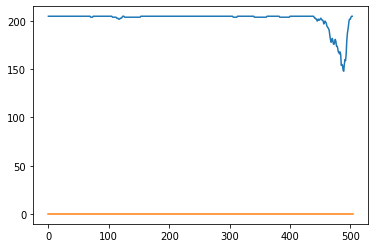

In [30]:
plot_data = df_occ_min[df_occ_min[COL_UNIDADE]==unidades[18]].reset_index()[COL_DISPONIVEIS]
_ = plt.plot(plot_data)
_ = plt.plot([0,len(plot_data)],[0,0])
plt.show()